# webtoon_anlaysis

___
### start of fining data

In [129]:
import csv
import MeCab
import pandas

In [130]:
def read_data(filename):
    with open(filename, 'r',encoding="cp949") as f:
        reader=csv.reader(f)
        lines=list(reader)
        data=[(line[1].replace("\n",""),int(line[2])) for line in lines[1:]]
        print(data[:2])
        texts,ok_points=zip(*data)
        return texts,ok_points
              
        
        
texts, ok_points = read_data('out_put1.csv')


[('잘 되었음 좋겠어요~ 주인공 소연이..', 63), ('핫식스 저렇게 먹으면 없어도 병 없어도 피토하겠다', 63)]


In [131]:
texts[-3:],ok_points[-3:]

(('오', '첫플?', '???'), (1, 1, 1))

In [132]:
len(texts)

111290

### 11만개의 열정호구 댓글을 크롤링 하였음

### start of word2vec
___

* mecap 토크나이저 이용


In [133]:
import MeCab
import re

In [134]:
t = MeCab.Tagger()

In [135]:
def mecab_NN_parse(text):
    parse_filter = re.compile(r'\S{2,8}\tNN')
    prep_text = parse_filter.findall(t.parse(text))
    nouns_text = [x.replace('\tNN', '') for x in prep_text]
    return nouns_text

In [136]:
prep_train1= list()
count = 0
for each_data in texts:
    doc = each_data
    prep_doc = mecab_NN_parse(doc)
    if len(prep_doc) > 0: prep_train1.append(prep_doc)
    count += 1
    if count%10000==0 or count==len(texts)-1: print(count, end='\r')

In [137]:
from gensim.models import Word2Vec

word2vec_model  = Word2Vec(prep_train1,
                          size=100,
                          alpha=0.025,
                          sg=0,
                          window=5,
                          min_count=5, 
                          workers=4,
                          negative=5)

In [138]:
word2vec_model.most_similar("좁쌀",topn=5)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('편집장', 0.9428114891052246),
 ('닷컴', 0.9028921723365784),
 ('여드름', 0.8865536451339722),
 ('좁살', 0.8748573660850525),
 ('얼굴', 0.8439409732818604)]

In [139]:
word2vec_model.most_similar("은지",topn=5)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('에이핑크', 0.8646122217178345),
 ('지은', 0.8574443459510803),
 ('바라기', 0.8014800548553467),
 ('포켓몬', 0.7979512214660645),
 ('초롱', 0.790814995765686)]

In [140]:
word2vec_model.most_similar("인턴",topn=5)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('업무', 0.9887537956237793),
 ('계약', 0.986021101474762),
 ('연봉', 0.9846107363700867),
 ('복지', 0.9829648733139038),
 ('시급', 0.98256516456604)]

In [141]:
word2vec_model.most_similar("정규직",topn=5)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('계약직', 0.9900237321853638),
 ('비정규직', 0.9825351238250732),
 ('개월', 0.9820199608802795),
 ('입사', 0.9549311399459839),
 ('전환', 0.9549287557601929)]

___
### end of word2vec

### start of clustering
___

In [142]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns

In [143]:
word2vec_model.wv.syn0.shape

(5374, 100)

In [144]:
word2vec_mecap=normalize(word2vec_model.wv.syn0,axis=1,norm="l2")

In [145]:
%%time
kmeans=KMeans(n_clusters=10,max_iter=300, n_init=2,verbose=0)
print('kmeans.fit_predict()')
clusters=kmeans.fit_predict(word2vec_mecap)
print('kmeans.fit_transform()')
distance = kmeans.fit_transform(word2vec_mecap)

kmeans.fit_predict()
kmeans.fit_transform()
Wall time: 521 ms


In [146]:
from collections import defaultdict

cluster_to_row = defaultdict(lambda: [])
for row_id, label in enumerate(clusters):
     cluster_to_row[label].append(row_id)
    
cluster_to_row = dict(cluster_to_row)
for label, rows in cluster_to_row.items():
    print('cluster # %d has %d words' % (label, len(rows)))

cluster # 3 has 169 words
cluster # 2 has 95 words
cluster # 5 has 234 words
cluster # 6 has 531 words
cluster # 0 has 188 words
cluster # 8 has 249 words
cluster # 4 has 967 words
cluster # 1 has 1454 words
cluster # 9 has 681 words
cluster # 7 has 806 words


In [147]:
voc=word2vec_model.wv.index2word

In [148]:
for label, rows in cluster_to_row.items():
    print('\ncluster # %d' % label)
    for row in rows[:8]:
        print('  > %s' % voc[row])


cluster # 3
  > 사람
  > 부모
  > 생각
  > 가족
  > 주인공
  > 친구
  > 정도
  > 자식

cluster # 2
  > 회사
  > 퇴사
  > 상사
  > 시간
  > 직장
  > 진상
  > 취업
  > 직원

cluster # 5
  > 작가
  > 사이다
  > 발암
  > 웹툰
  > 만화
  > 현실
  > 고구마
  > 공감

cluster # 6
  > 좁쌀
  > 소연
  > 편집장
  > 여주
  > 진심
  > 새끼
  > 이름
  > 얼굴

cluster # 0
  > 엄마
  > 동생
  > 아빠
  > 공부
  > 학교
  > 머리
  > 언니
  > 대학

cluster # 8
  > 여자
  > 남자
  > 나이
  > 결혼
  > 나라
  > 연애
  > 한국
  > 여성

cluster # 4
  > 은지
  > 시작
  > 차장
  > 징징
  > 박근혜
  > 최고
  > 내일
  > 대리

cluster # 1
  > 구호
  > 주제
  > 중간
  > 탕수육
  > 타령
  > 기기
  > 장애
  > 여친

cluster # 9
  > 지은
  > 동안
  > 부장
  > 예전
  > 병원
  > 자괴감
  > 팀장
  > 실력

cluster # 7
  > 대가리
  > 바보
  > 어머님
  > 기회
  > 방법
  > 망이
  > 걸까
  > 연락


___
## clustering visulaization

In [149]:
kmeans.cluster_centers_.shape

(10, 100)

In [150]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

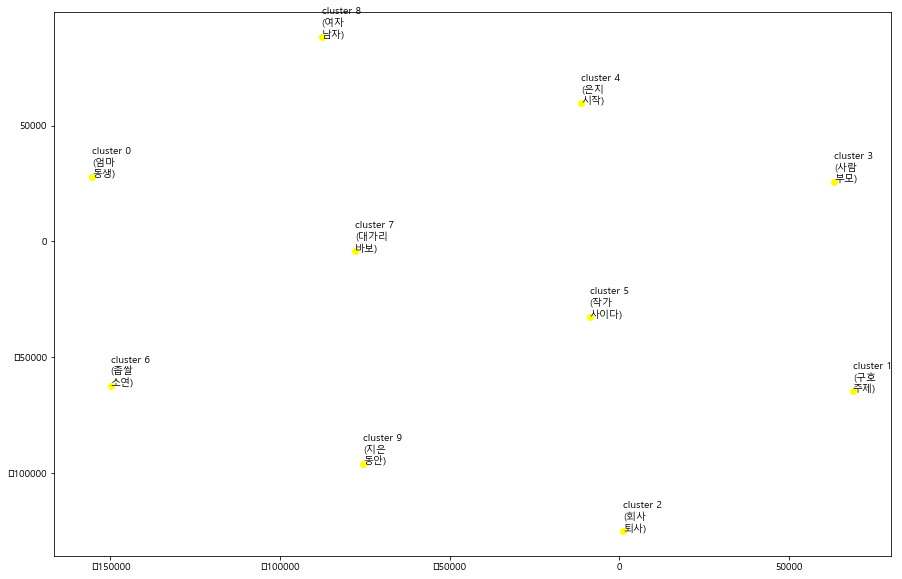

In [151]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
y_tsne = tsne.fit_transform(kmeans.cluster_centers_)
y_tsne = y_tsne*1000


plt.figure(figsize=(15,10))
plt.scatter(y_tsne[:,0], y_tsne[:,1], color='yellow')
for i in range(y_tsne.shape[0]):
    one_sample = voc[cluster_to_row[i][0]]
    two_sample = voc[cluster_to_row[i][1]]
    plt.annotate('cluster %d \n(%s\n%s)' % (i, one_sample, two_sample), 
                 (y_tsne[i, 0], y_tsne[i, 1])
                )
plt.show()

In [31]:
%%time 

from sklearn.manifold import MDS

mds = MDS(n_components=2)
y_mds = mds.fit_transform(kmeans.cluster_centers_)

y_mds.shape

Wall time: 28.1 ms


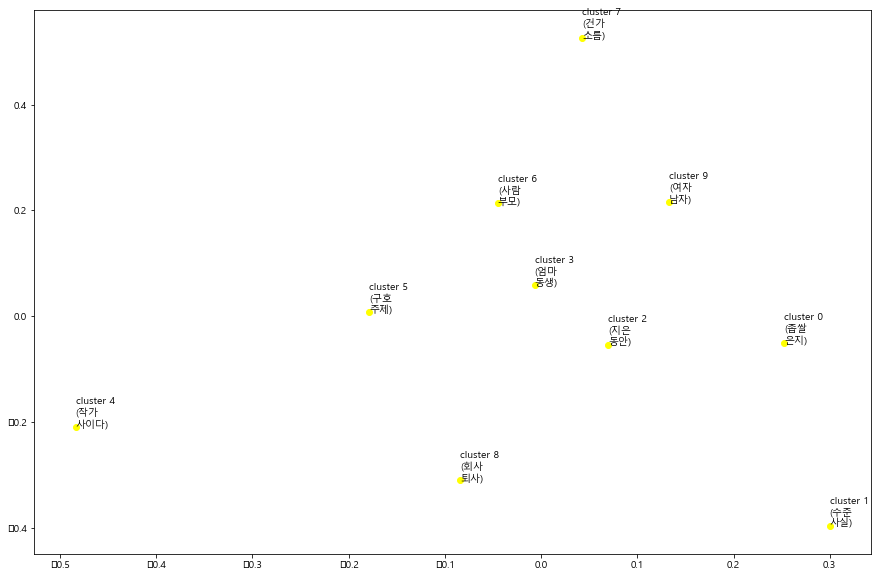

In [32]:
plt.figure(figsize=(15,10))
plt.scatter(y_mds[:,0], y_mds[:,1], color='yellow')
for i in range(y_tsne.shape[0]):
    one_sample = voc[cluster_to_row[i][0]]
    two_sample = voc[cluster_to_row[i][1]]
    plt.annotate('cluster %d \n(%s\n%s)' % (i, one_sample, two_sample), 
                 (y_mds[i, 0], y_mds[i, 1])
                )
plt.show()

